In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gym
import numpy as np
import tensorflow as tf
from policy_net_breakout import Policy_net
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt

F:\Anaconda3_Reinstall\envs\atari_breakout_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
F:\Anaconda3_Reinstall\envs\atari_breakout_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
F:\Anaconda3_Reinstall\envs\atari_breakout_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
F:\Anaconda3_Reinstall\envs\atari_breako

In [2]:
target_score = 16

In [3]:
modeldir = "trained_models/gail"
model = 'GAIL_model_breakout-v0_1000iter.ckpt'

logdir = 'log/test/gail'
numepisodes = int(1e3)
#numepisodes = int(100)

In [4]:
def preprocess_obs_state(obs):
    obs = np.resize(obs , (84,84,4))
    obs = np.stack([obs]).astype(dtype=np.float32)
    return obs

In [5]:
def main():
    env = gym.make('Breakout-v0')
    env.seed(0)
    Policy = Policy_net('policy', env)
    
    expert_path = "expert_trajectory/expert_breakout_v0.npz"
    expert_traj_data = np.load(expert_path)
    expert_episode_returns = expert_traj_data["episode_returns"]

    sum_rewardsperepisode_list = []

    rewards_wndw = deque(maxlen=100) #last 100 scores

    saver = tf.compat.v1.train.Saver()

    with tf.Session() as sess:
        writer = tf.summary.FileWriter(logdir+'/', sess.graph)
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, modeldir  +'/' + model )

        obs = env.reset()
        reward = 0
        success_num = 0

        for iteration in range(numepisodes):
            rewards = []
            run_policy_steps = 0
            reward = 0
            while True:  # run policy RUN_POLICY_STEPS which is much less than episode length
                run_policy_steps += 1
                obs = preprocess_obs_state(obs)  # preprocess the state to feed placeholder Policy.input_normalized
            
                act, _ = Policy.act(obs=obs)

                act = np.asscalar(act)

                rewards.append(reward)

                next_obs, reward, done, info = env.step(act)
                env.render()
                if done:
                    obs = env.reset()
                    break
                else:
                    obs = next_obs
            
            writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag='episode_length', simple_value=run_policy_steps)])
                               , iteration)
            writer.add_summary(tf.Summary(value=[tf.Summary.Value(tag='episode_reward', simple_value=sum(rewards))])
                               , iteration)

            
            render = True

            #print(" TOTAL REWARDS IN EPISODE " + str(iteration) + " : " + str(sum(rewards)))

            sum_rewardsperepisode_list.append(sum(rewards))
            rewards_wndw.append(sum(rewards))

            if(iteration%100 == 0 and iteration > 0 ):
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(iteration, np.mean(rewards_wndw)))
            # end condition of test
            if (np.mean(rewards_wndw) >= target_score):
                print('Target Score of 16 reached consistently over a range of 100 episodes.')


        writer.close()
        env.close()
        
        return expert_episode_returns , sum_rewardsperepisode_list

ob_space
Box(0, 255, (210, 160, 3), uint8)
act_space
Discrete(4)
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from trained_models/gail/1000_iter_v2_model/GAIL_model_breakout-v0_1000iter.ckpt



F:\Anaconda3_Reinstall\envs\atari_breakout_env_1\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Episode 100	Average Score: 1.36
Episode 200	Average Score: 1.58
Episode 300	Average Score: 1.49
Episode 400	Average Score: 1.74
Episode 500	Average Score: 1.51
Episode 600	Average Score: 1.36
Episode 700	Average Score: 1.50
Episode 800	Average Score: 1.43
Episode 900	Average Score: 1.72


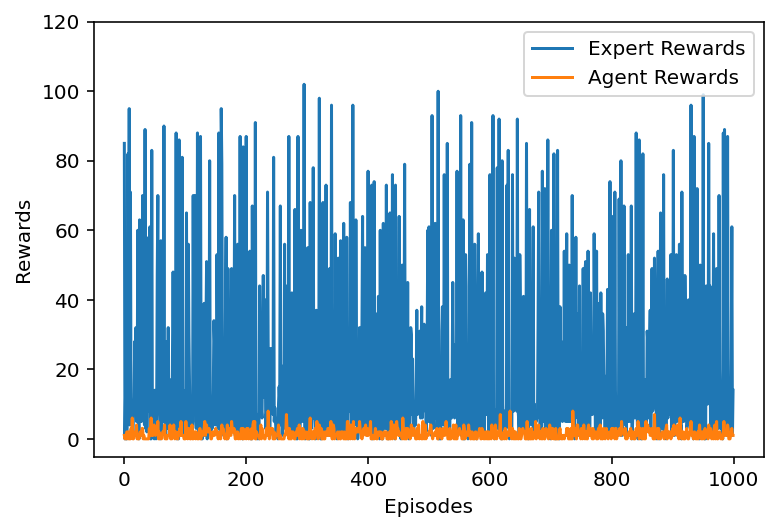

In [6]:
if __name__ == '__main__':
    expert_rewards_list =[]
    agent_rewards_list = []
    expert_rewards_list , agent_rewards_list =  main()
    plt.plot(expert_rewards_list , label='Expert Rewards')
    plt.plot(agent_rewards_list, label='Agent Rewards')
    plt.legend()
    plt.ylim(ymax=120)
    plt.ylabel("Rewards")
    plt.xlabel("Episodes")